In [144]:
import pandas as pd
import glob
import spotipy
from scipy import stats
from spotipy.oauth2 import SpotifyOAuth
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import os
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import levene

In [145]:
folder_path = '/Users/adriamulero/opt/anaconda3/DATASCIENCE_PROJECTS/spotify_proto'
csv_files = glob.glob(f"{folder_path}/*.csv")

def_dict = {}

# Getting the default mbti type data column names
column_names_aux = list(pd.read_csv("ESTJ_df.csv").columns)

#Cleaning column names
# Setting an empty list for cleaned column names
column_names= []
# Cleaning through column_names_aux
for name in column_names_aux:
    stat = str(name).split("_")[-1]
    if stat == "mean":
        column_names.append(name)
    elif name == "mbti":
        column_names.append(name)

print(column_names)

# Proceeding with analysis
results = {} # for storing cross-analysis data for each MBTI type

# Comparing user's playlist data with each MBTI type
for file in csv_files:
    if file.endswith(".csv"):  # Make sure you're only reading CSV files
        # Determine the delimiter based on the file content
        with open(file, "r") as f:
            first_line = f.readline()
            if ";" in first_line:
                delimiter = ";"
            else:
                delimiter = ","
    type_data = pd.read_csv(file, delimiter=delimiter)

    # New dict for each FUNCTION PAIR (with the columns needed)
    aux_df = {}
    mbti_type = str(type_data.mbti.iloc[0])

    for n in range(len(column_names)):
        aux_df[column_names[n]] = type_data[column_names[n]]

    def_dict[mbti_type] = pd.DataFrame(aux_df)

['mbti', 'danceability_mean', 'energy_mean', 'loudness_mean', 'mode_mean', 'speechiness_mean', 'acousticness_mean', 'liveness_mean', 'valence_mean', 'tempo_mean', 'instrumentalness_mean']


In [146]:
print(def_dict)

{'ISFJ':      mbti  danceability_mean  energy_mean  loudness_mean  mode_mean  \
0    ISFJ           0.583120     0.485660      -8.549820   0.900000   
1    ISFJ           0.524700     0.541100      -9.416880   0.640000   
2    ISFJ           0.551960     0.515860      -8.020940   0.740000   
3    ISFJ           0.463791     0.653977      -6.639674   0.906977   
4    ISFJ           0.528700     0.592150      -7.423600   0.850000   
..    ...                ...          ...            ...        ...   
216  ISFJ           0.641550     0.606450      -6.078900   0.300000   
217  ISFJ           0.546540     0.709466      -7.044500   0.420000   
218  ISFJ           0.557176     0.571118      -6.829647   0.823529   
219  ISFJ           0.735320     0.743180      -5.861640   0.620000   
220  ISFJ           0.531600     0.521670     -10.506900   0.800000   

     speechiness_mean  acousticness_mean  liveness_mean  valence_mean  \
0            0.064690           0.468500       0.149110      0.39

In [147]:
# Stacking all DataFrames
df = pd.DataFrame()
for key in def_dict:
    df = pd.concat([df, def_dict[key]], ignore_index=True)

In [148]:
# Creating 8 columns for the cognitive functions.
    # The idea is to order them descently, meaning that the first function will have a value of 3, 
    # the auxiliar of 2, the third one 1 and the shadow and last one a -1.
    # The other 4 will remain 0.
cognitive_functions = ["Se", "Si", "Ne", "Ni", "Te", "Ti", "Fe", "Fi"]
for col in cognitive_functions:
    df[col] = None

In [149]:
opps_func = {'Se': 'Ni', 'Si': 'Ne', 'Ti': 'Fe', 'Te': 'Fi', 'Ni': 'Se', 'Ne': 'Si', 'Fe': 'Ti', 'Fi': 'Te'}
opps_att = {"i":"e", "e":"i"}

def cog_fun_decoder(mbti_cat):
    A = str(mbti_cat)[0]
    B = str(mbti_cat)[1]
    C = str(mbti_cat)[2]
    D = str(mbti_cat)[3]
    
    # Dominant function attitude is represented by A
    if A == "E":
        dom_att = "e"
        aux_att ="i"
        # Last letter refers to the second function
        if D == "J": # judging functions are T and F
            dom_func = C
            aux_func = B 

        else:  # perceiving functions are S and N
            dom_func = B
            aux_func = C 

    else: 
        dom_att = "i"
        aux_att = "e"
        # Last letter refers to the second function
        if D == "J": # judging functions are T and F
            dom_func = B
            aux_func = C 

        else: 
            dom_func = C
            aux_func = B 
    
    # Four main cognitive functions: Dominant, Auxiliar, Third/Child and Inferior
    dom = dom_func + dom_att
    aux = aux_func + aux_att
    third = opps_func[aux]
    inf = opps_func[dom]

    # Getting the other 4
    third_func = opps_func[aux][0]
    third_att = opps_att[aux[1]]
    inf_func = opps_func[dom][0]
    inf_att = opps_att[dom[1]]

    # Attiude just means (i)ntroversion or (e)xtraversion
    opp_pers = dom_func + opps_att[dom_att] 
    critical = aux_func + opps_att[aux_att]
    trickster = third_func + opps_att[third_att]
    demon = inf_func + opps_att[inf_att]
    result = {dom: 4, aux:3, third:2, inf:1, opp_pers:-1, critical:-2, trickster:-3, demon:-4}
    
    return result

cog_fun_decoder("ESFP")

{'Se': 4, 'Fi': 3, 'Te': 2, 'Ni': 1, 'Si': -1, 'Fe': -2, 'Ti': -3, 'Ne': -4}

In [150]:
# Filling in the DataFrame with the correspondant value of the cognitive functions stack (range = [4, -4])
for pers in df['mbti'].unique():
    aux_dict = cog_fun_decoder(pers)
    filter_condition = df['mbti'] == pers
    
    for key in aux_dict:
        df.loc[filter_condition, key] = aux_dict[key]

In [151]:
# Checking if data is placed right
for pers in df['mbti'].unique():
    sampled_row = df[df['mbti'] == pers].sample()
    print(sampled_row)


     mbti  danceability_mean  energy_mean  loudness_mean  mode_mean  \
181  ISFJ           0.643474     0.673368      -4.975263   0.578947   

     speechiness_mean  acousticness_mean  liveness_mean  valence_mean  \
181          0.065558           0.188369       0.206174      0.474053   

     tempo_mean  instrumentalness_mean  Se Si Ne  Ni  Te Ti Fe  Fi  
181  118.100947               0.000362  -1  4  1  -4  -3  2  3  -2  
     mbti  danceability_mean  energy_mean  loudness_mean  mode_mean  \
300  INTJ            0.61862      0.54978        -8.3861       0.62   

     speechiness_mean  acousticness_mean  liveness_mean  valence_mean  \
300          0.093034           0.259724       0.196032      0.409376   

     tempo_mean  instrumentalness_mean Se  Si  Ne Ni Te  Ti  Fe Fi  
300    121.6831               0.146356  1  -4  -1  4  3  -2  -3  2  
     mbti  danceability_mean  energy_mean  loudness_mean  mode_mean  \
588  INTP             0.6103      0.63022       -6.65016       0.82   

 

In [152]:
cog_funs = df.columns[11:]
audio_features = df.columns[1:11]

In [153]:
test = df.danceability_mean[df.Si == -1].mean()
print(test)

0.6390501312955372


In [154]:
df.groupby("Se")
print(df.groupby("Se"))

In [155]:
df.groupby("Se").head()

,mbti,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean,Se,Si,Ne,Ni,Te,Ti,Fe,Fi
0,ISFJ,0.583120,0.485660,-8.549820,0.900000,0.064690,0.468500,0.149110,0.398722,109.274980,0.020547,-1,4,1,-4,-3,2,3,-2
1,ISFJ,0.524700,0.541100,-9.416880,0.640000,0.049626,0.423719,0.172712,0.411386,120.891240,0.157191,-1,4,1,-4,-3,2,3,-2
2,ISFJ,0.551960,0.515860,-8.020940,0.740000,0.047872,0.409239,0.206710,0.372836,120.063660,0.063386,-1,4,1,-4,-3,2,3,-2
3,ISFJ,0.463791,0.653977,-6.639674,0.906977,0.033612,0.174063,0.209614,0.215263,135.055698,0.043192,-1,4,1,-4,-3,2,3,-2
4,ISFJ,0.528700,0.592150,-7.423600,0.850000,0.043815,0.311781,0.164070,0.449050,139.767350,0.095677,-1,4,1,-4,-3,2,3,-2
221,INTJ,0.578360,0.655980,-7.076460,0.420000,0.087814,0.220719,0.194400,0.480800,123.465140,0.030866,1,-4,-1,4,3,-2,-3,2
222,INTJ,0.615960,0.664860,-6.128720,0.480000,0.088132,0.171925,0.161082,0.502086,116.274520,0.027026,1,-4,-1,4,3,-2,-3,2
223,INTJ,0.671279,0.167297,-14.608721,0.581395,0.099702,0.579851,0.111479,0.557698,98.777674,0.857023,1,-4,-1,4,3,-2,-3,2
224,INTJ,0.692100,0.663560,-6.542580,0.540000,0.086398,0.128614,0.206846,0.509520,122.102040,0.079860,1,-4,-1,4,3,-2,-3,2
225,INTJ,0.502980,0.631946,-6.798660,0.520000,0.045908,0.233917,0.178104,0.456420,120.814060,0.149675,1,-4,-1,4,3,-2,-3,2


Ti
-4    0.571805
-3    0.625829
-2    0.565078
-1    0.631717
 1    0.589848
 2    0.555512
 3    0.631184
 4    0.586614
Name: danceability_mean, dtype: float64


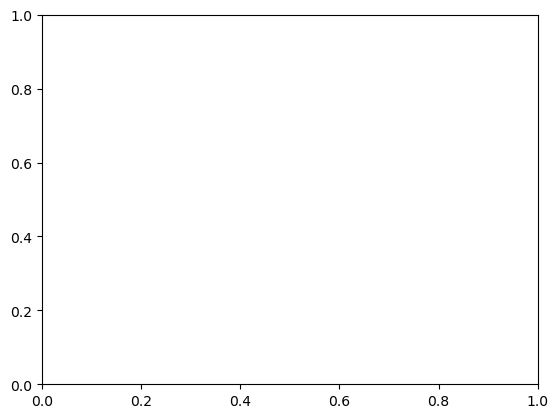

In [161]:
fig, ax = plt.subplots()
mean_data = {}
# Loop through selected columns and functions
for a_f in audio_features:  # Adjust the range if you have more than 2 columns
    mean_data[a_f] = {}  # To store mean values for each function
    for func in cog_funs:
        # Group by both 'a_f' and 'Function', then calculate the mean within each group
        mean_val = df.groupby(func)[a_f].mean()
        mean_data[a_f][func] = mean_val
print(mean_data["danceability_mean"]["Ti"])
    

        


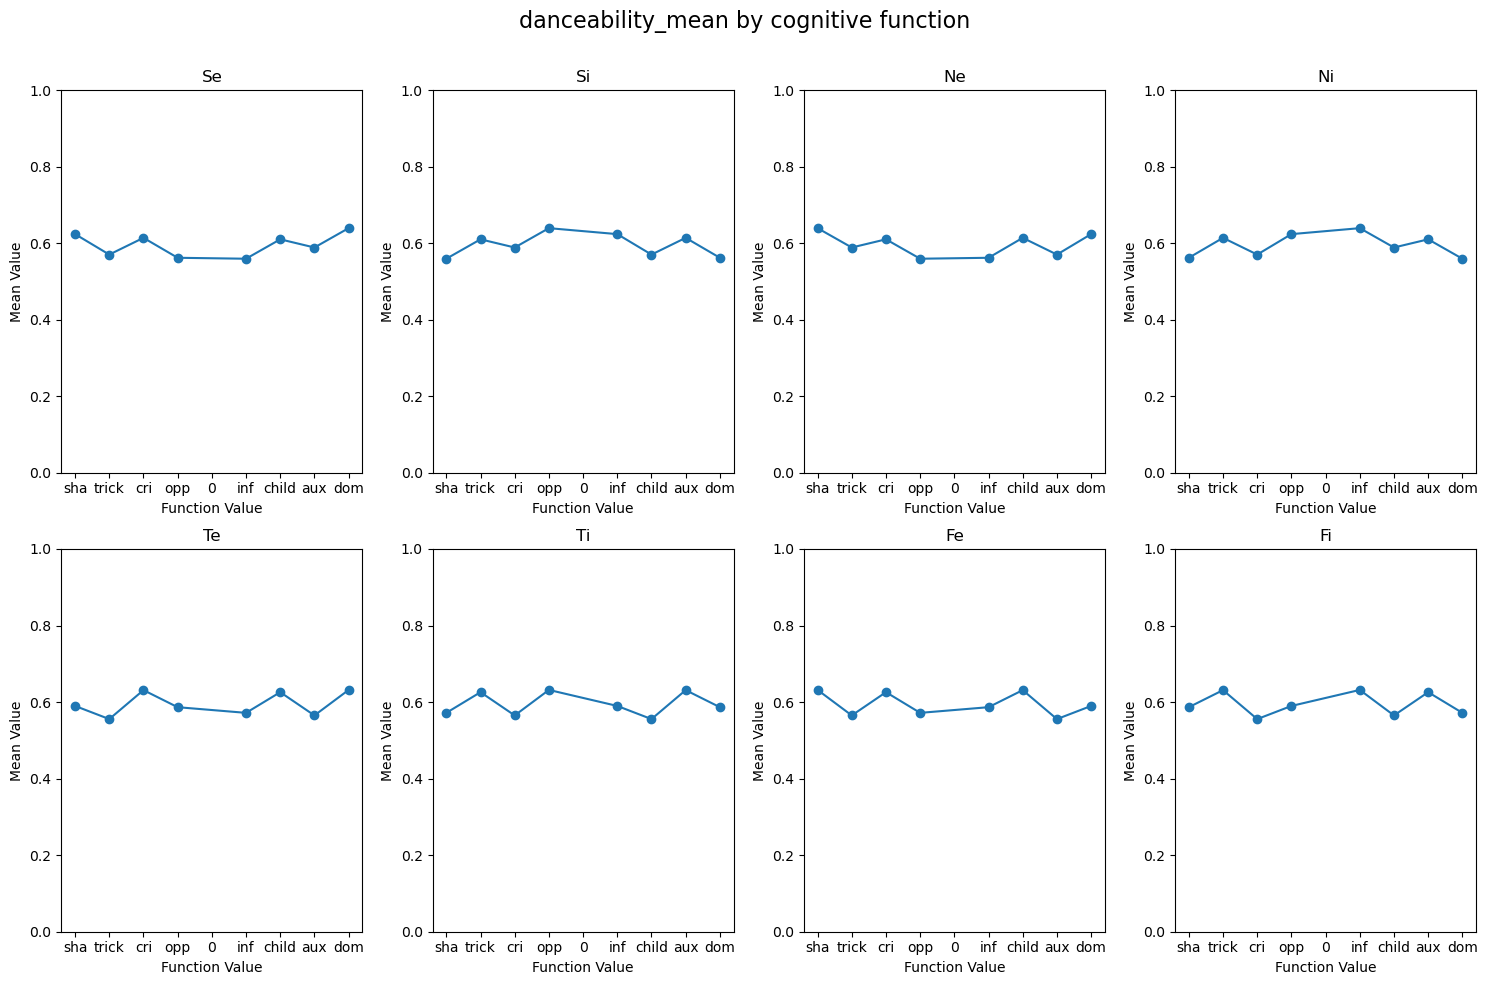

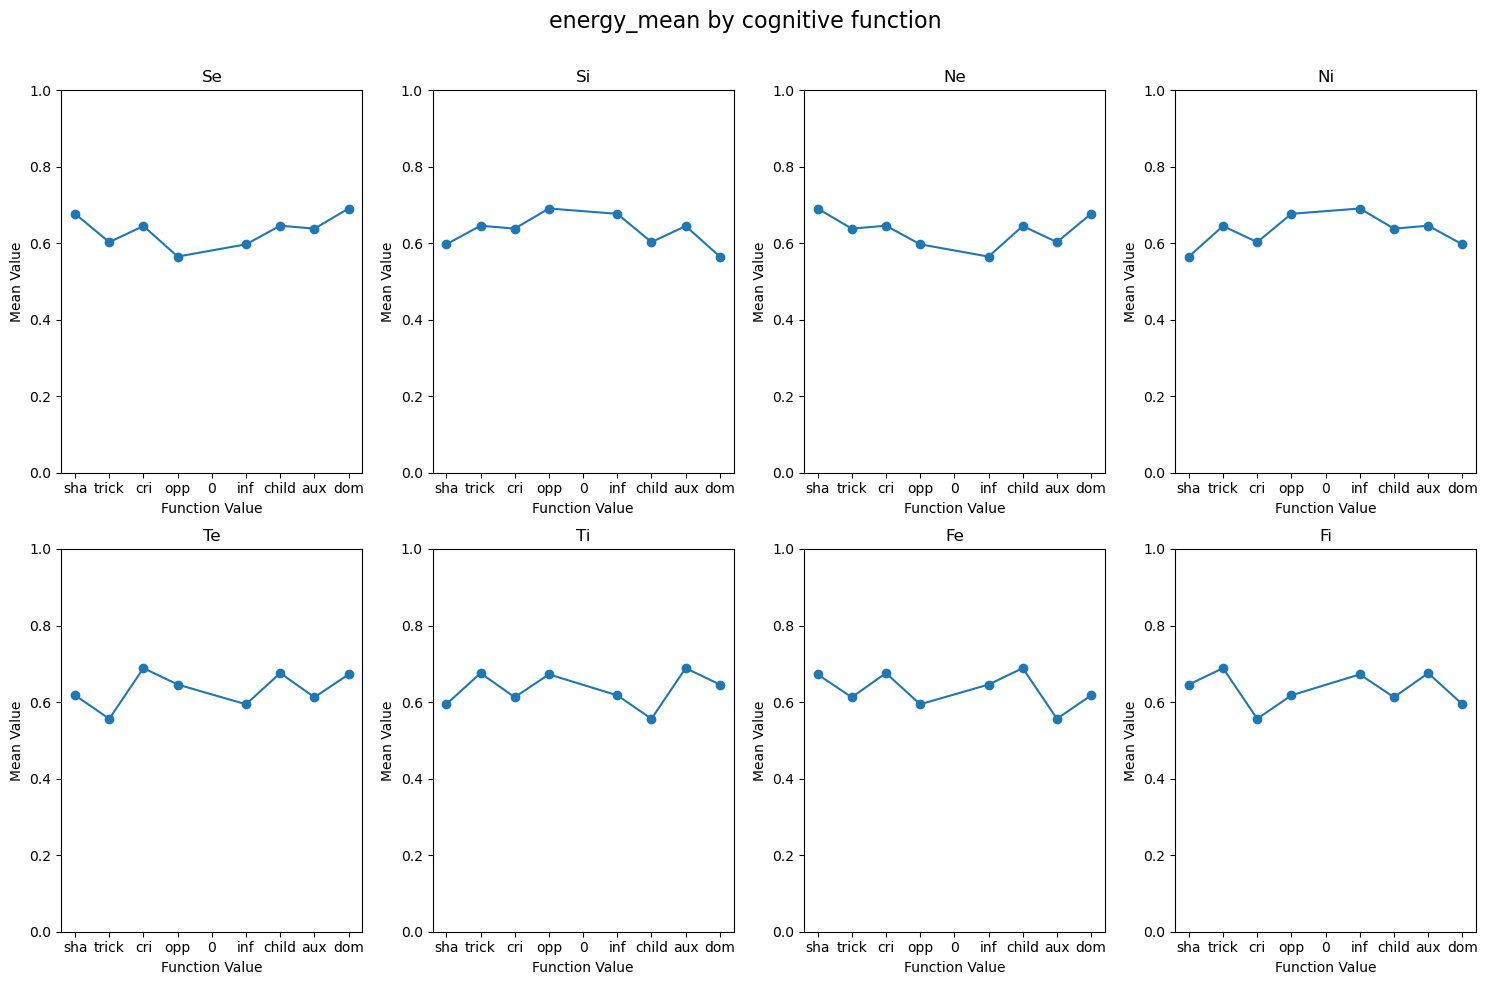

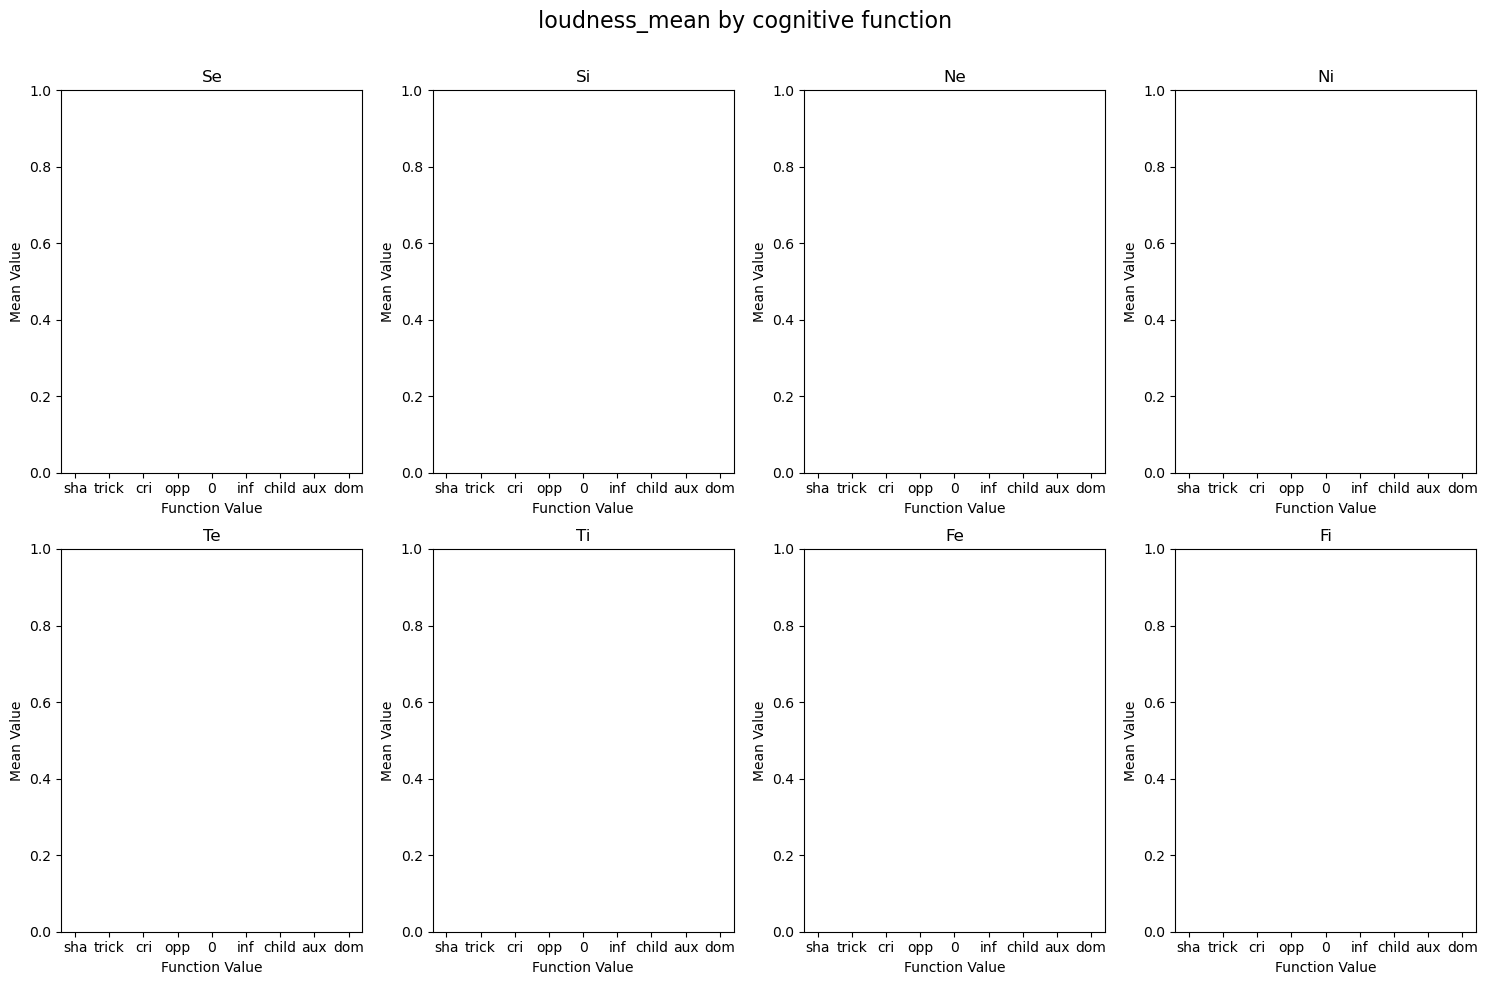

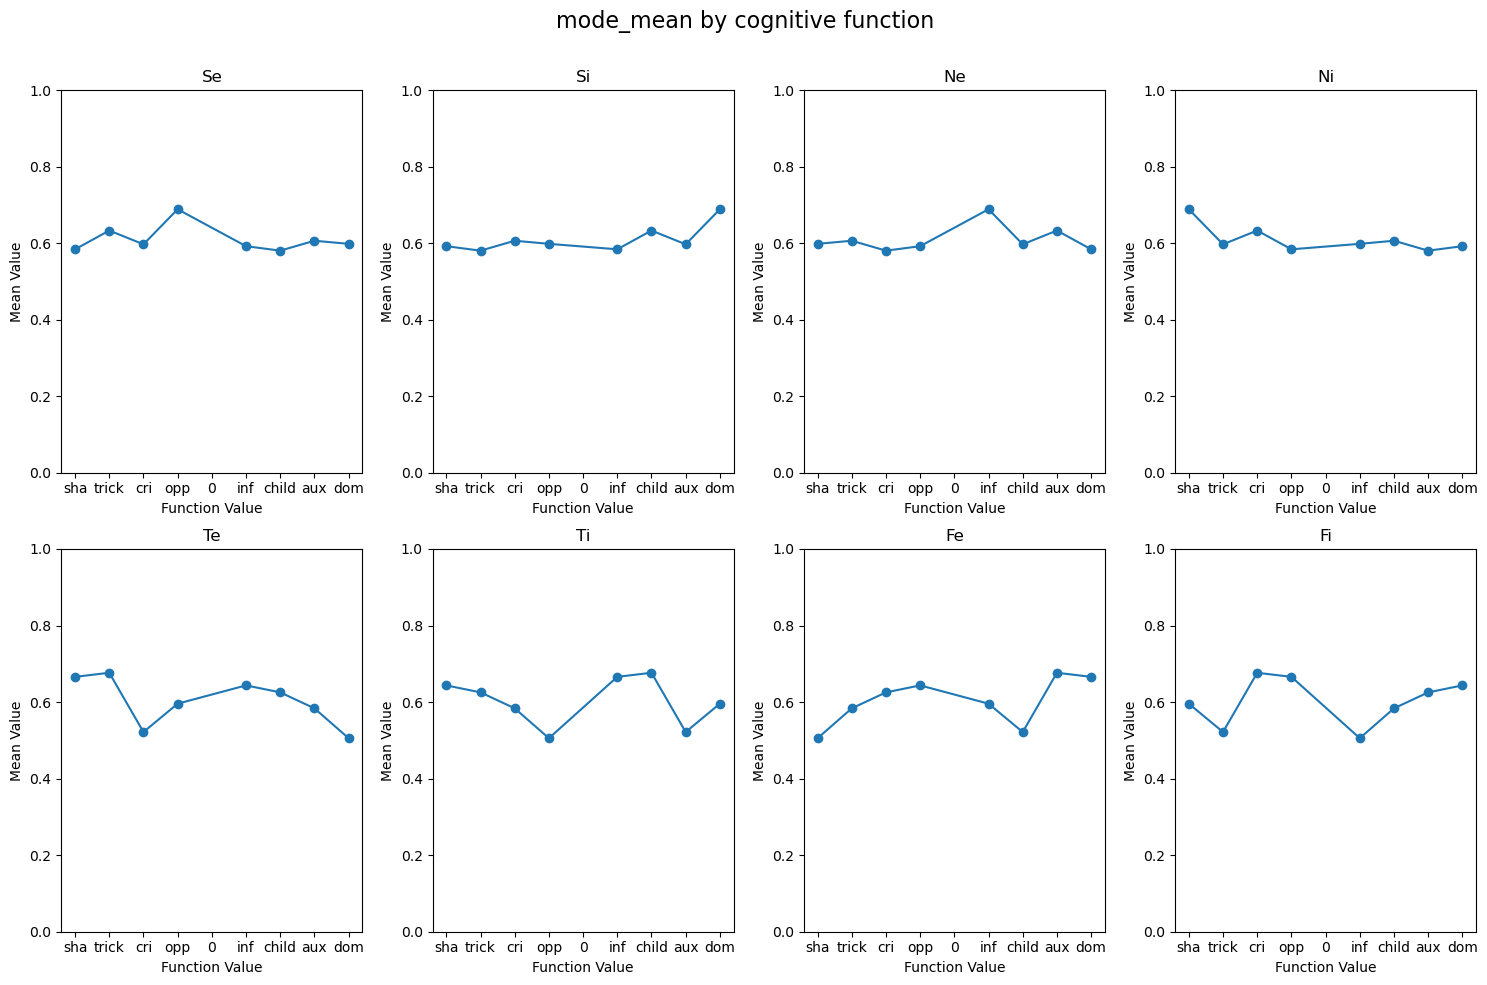

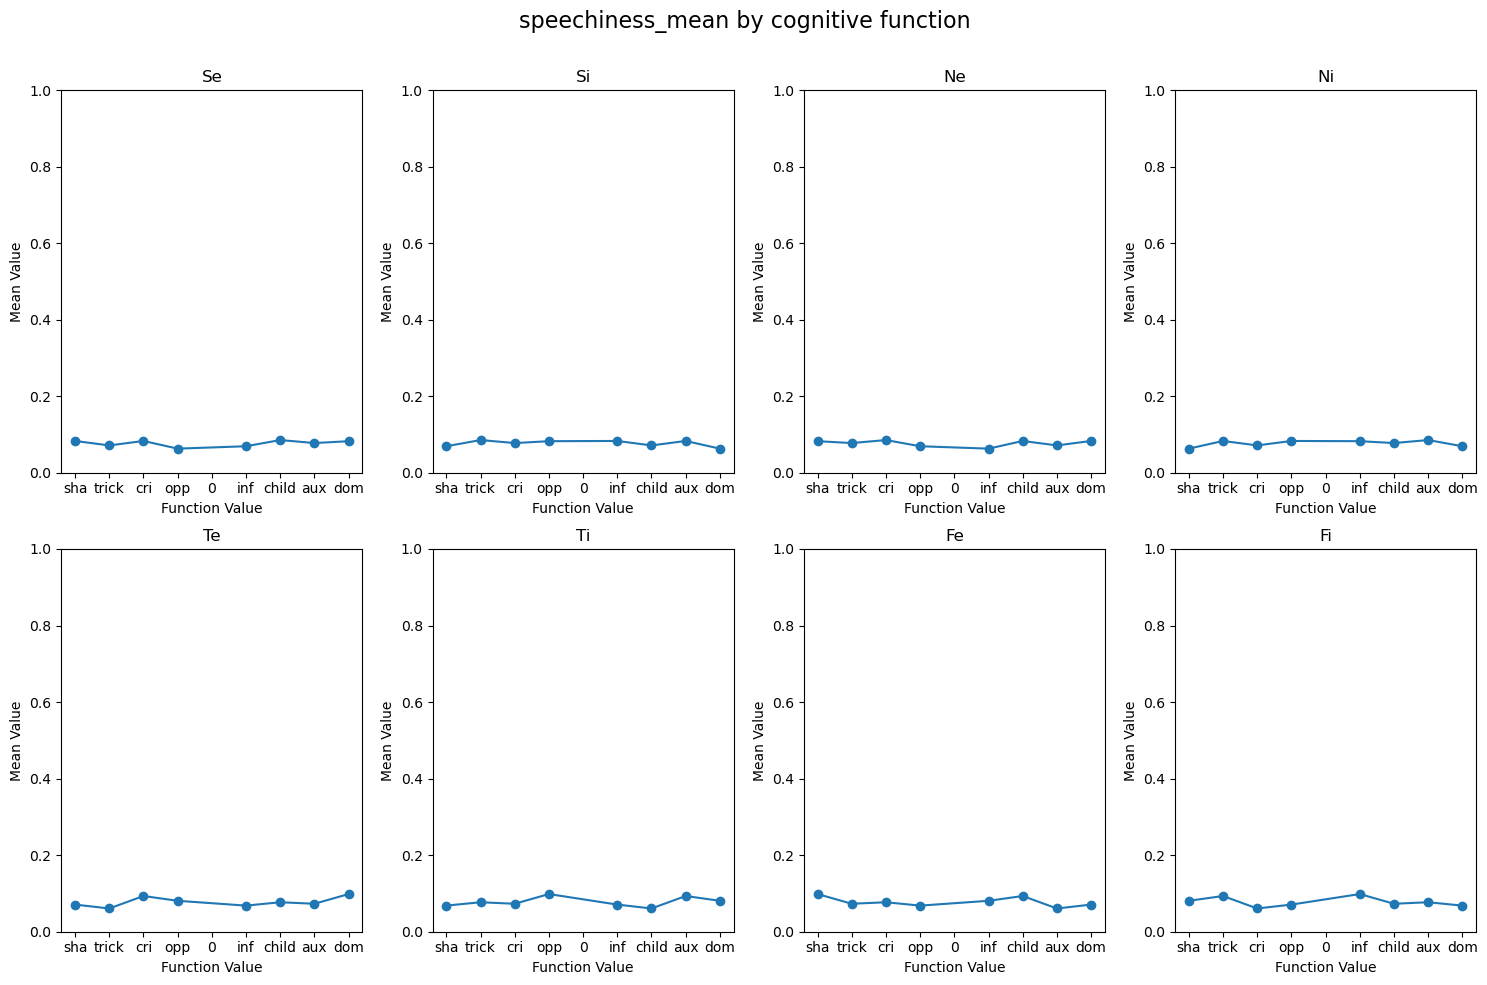

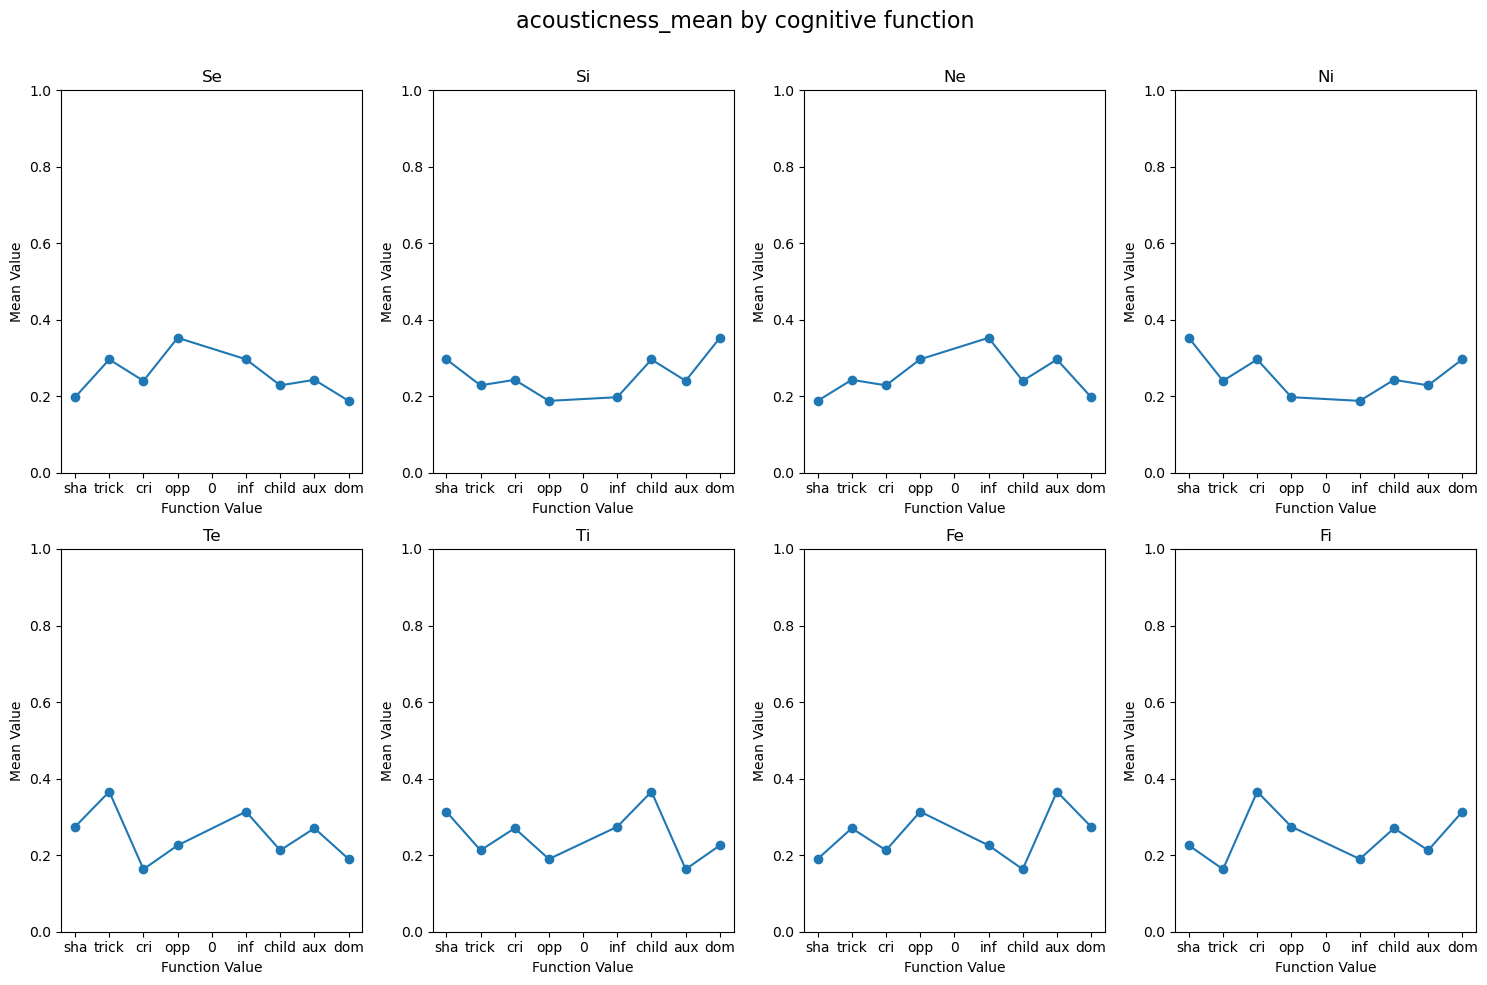

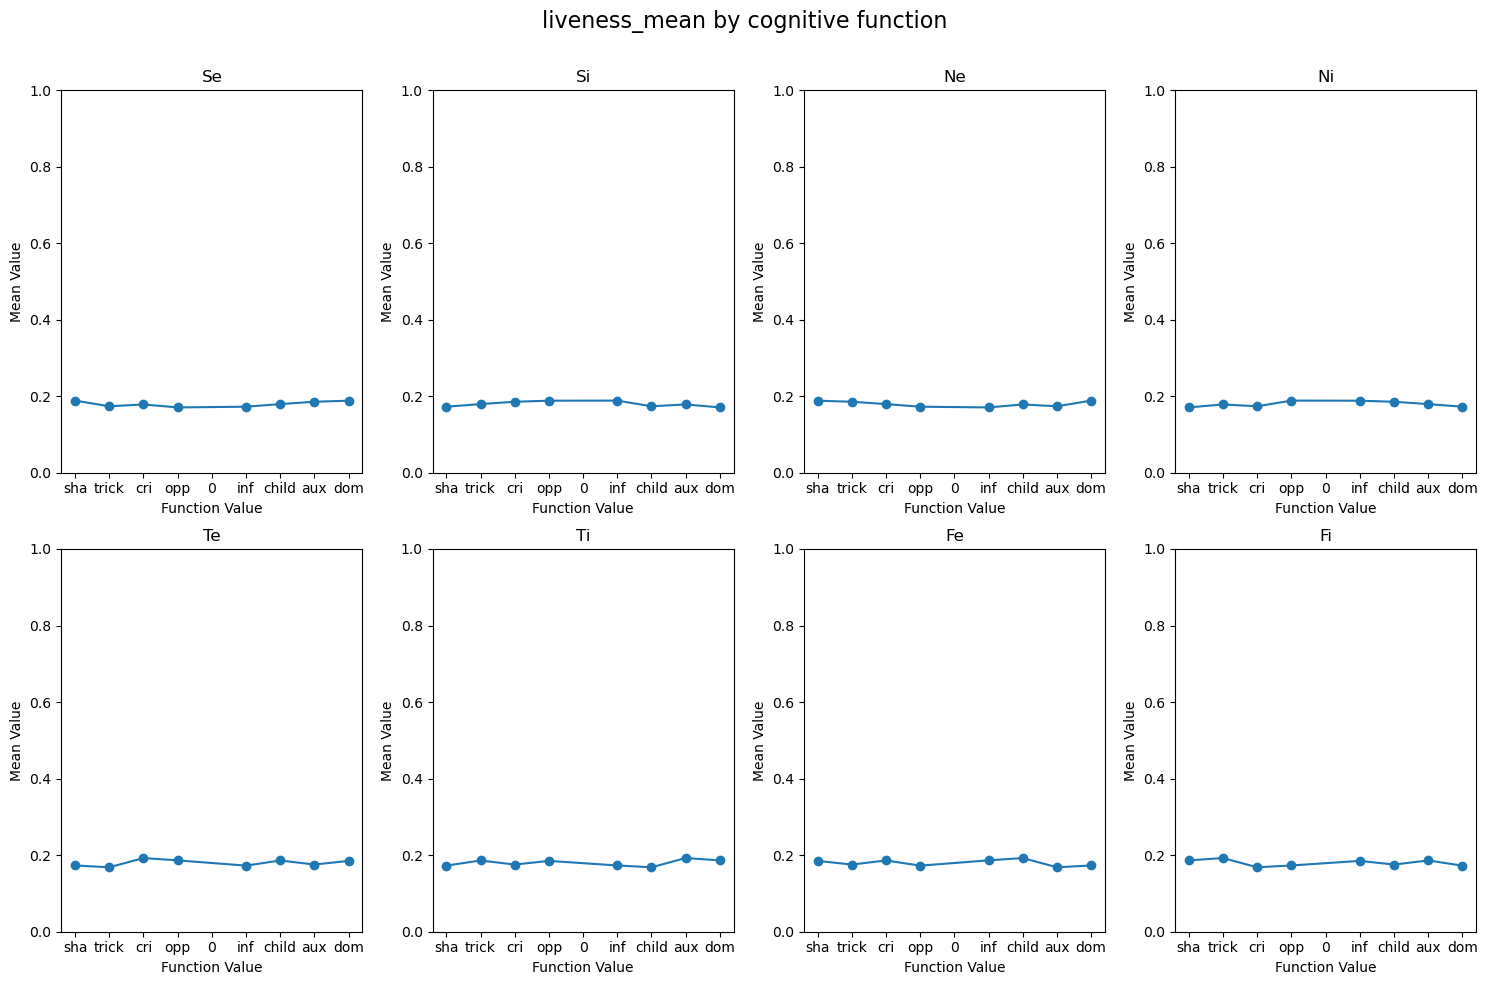

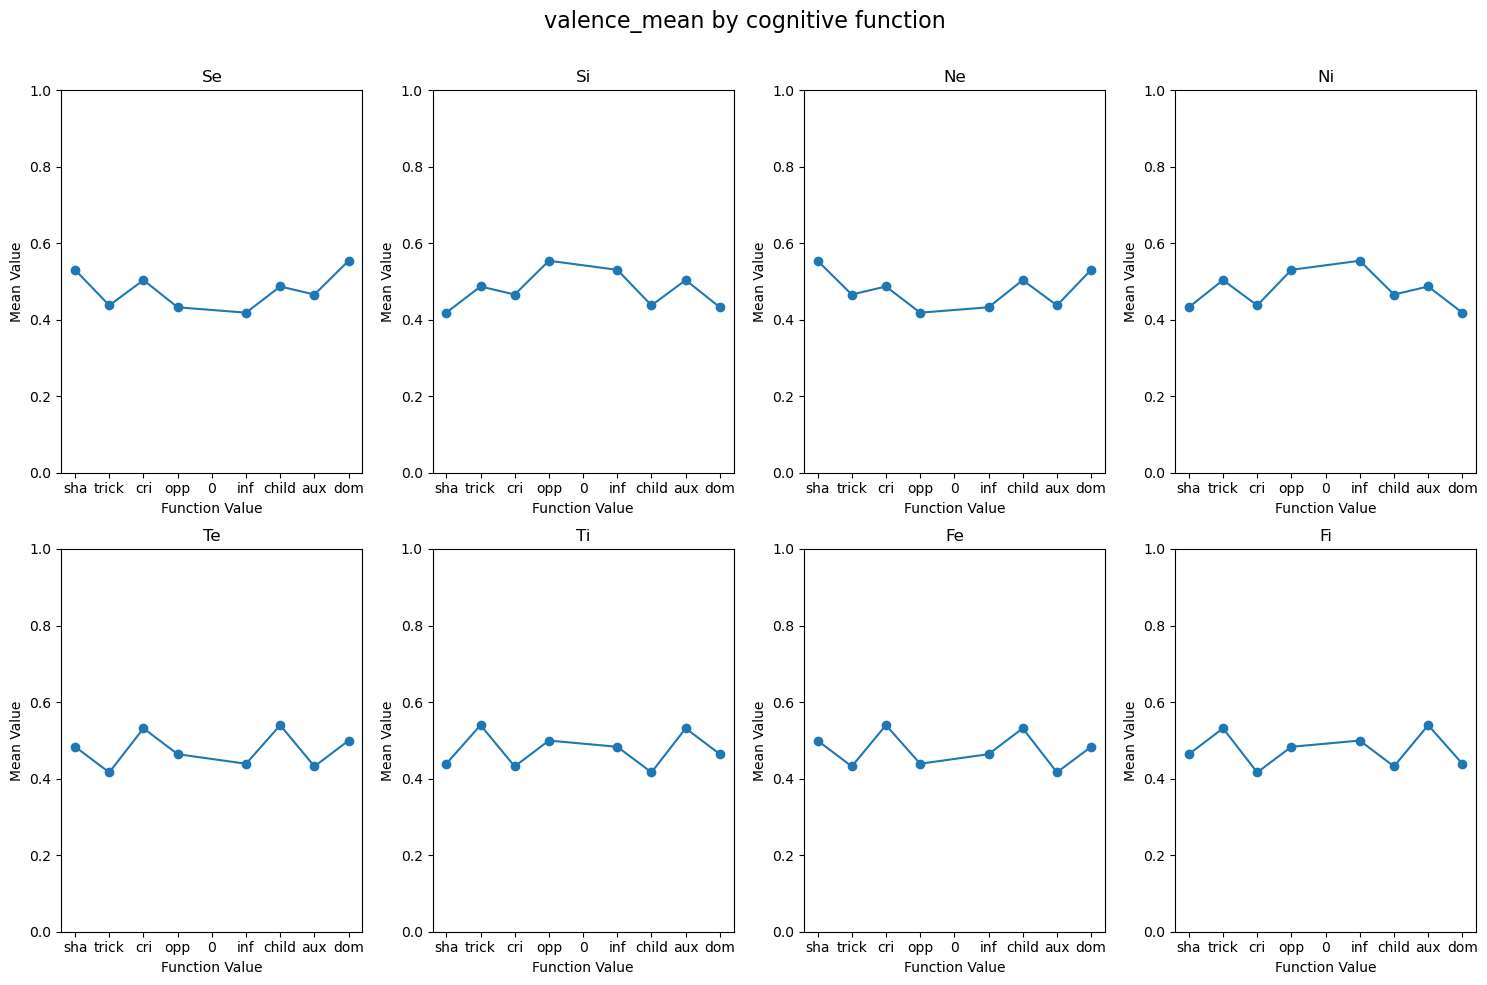

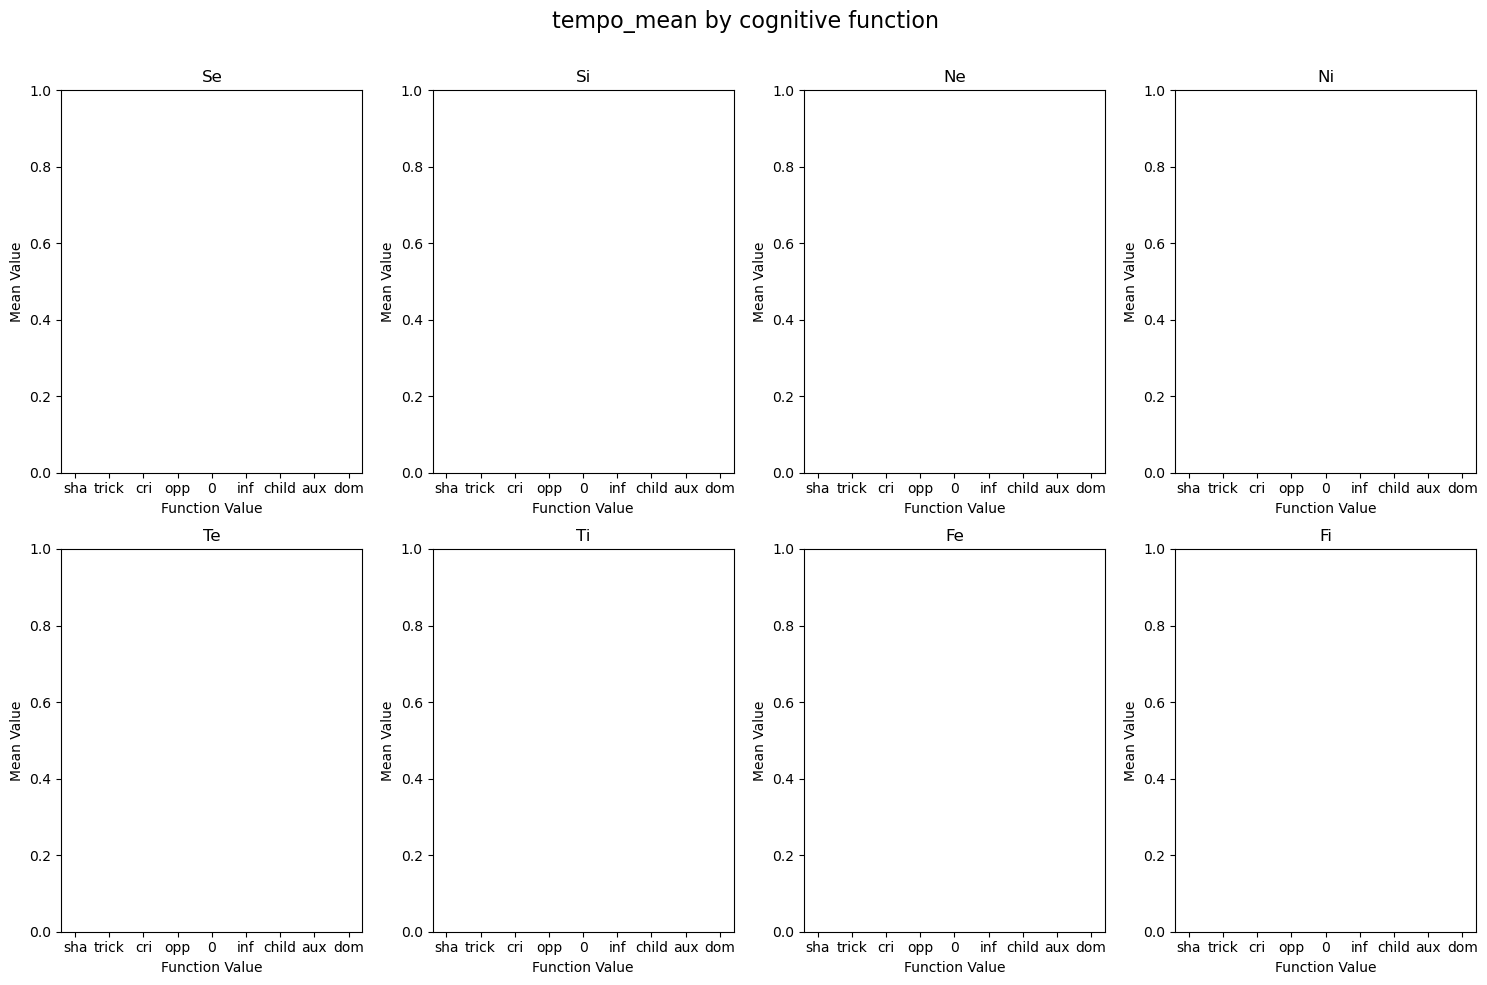

In [178]:
import matplotlib.pyplot as plt

# Assuming you have the data already loaded and calculated as mentioned in your question
# audio_features is the list of audio features
# cog_funs is the list of cognitive functions
# mean_data is the dictionary containing mean values for each combination of 'a_f' and 'func'

# Loop through audio_features
for a_f in audio_features:
    # Create a figure with 8 subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
    fig.suptitle(f'{a_f} by cognitive function', fontsize=16)

    # Flatten the axes for easy iteration
    axes = axes.flatten()

    # Loop through cog_funs and corresponding axes
    for func, ax in zip(cog_funs, axes):
        mean_val = mean_data[a_f][func]  # Get mean values for the specific combination
        ax.plot(mean_val.index, mean_val.values, "-o")
        ax.set_title(func)
        ax.set_ylim(0, 1)  # Adjust y-axis limits if necessary
        ax.set_xlabel('Function Value')
        ax.set_ylabel('Mean Value')
        ax.set_xticks(range(-4,5,1))
        ax.set_xticklabels(["sha", "trick", "cri", "opp","0", "inf", "child", "aux", "dom"])

    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust the placement of the title
    plt.show()
